<a href="https://colab.research.google.com/github/apreshagarwal/ASL_Deep_Learning/blob/master/Interpreting_the_Sign_Language_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Required Imports
import numpy as np
import pandas as pd
import matplotlib as mtpb
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelBinarizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print("Numpy Version", np.__version__)
print("Pandas Version", pd.__version__)
print("Matplotlib Version", mtpb.__version__)
print("Seaborn Version", sns.__version__)
print("Tensorflow Version", tf.__version__)
print("Keras Version", keras.__version__)
print("Scikit Learn Version", skl.__version__)

Numpy Version 1.18.5
Pandas Version 1.0.5
Matplotlib Version 3.2.2
Seaborn Version 0.10.1
Tensorflow Version 2.3.0
Keras Version 2.4.0
Scikit Learn Version 0.22.2.post1


In [ ]:
# Loading the Dataset
train_df = pd.read_csv("/content/drive/My Drive/Summer Internship - Deep Learning using Python R/Dataset/Sign Language - 1/sign_mnist_train.csv")
test_df = pd.read_csv("/content/drive/My Drive/Summer Internship - Deep Learning using Python R/Dataset/Sign Language - 1/sign_mnist_test.csv")

In [ ]:
print("Training Dataset Size: %d" % (train_df['label'].count()))
print("Testing Dataset Size: %d" % (test_df['label'].count()))

Training Dataset Size: 27455
Testing Dataset Size: 7172


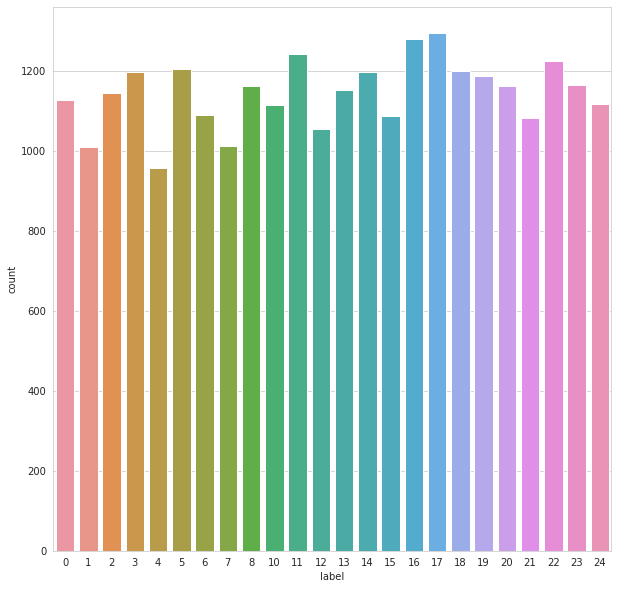

In [ ]:
plt.figure(figsize = (10,10))
sns.set_style("whitegrid")
sns.countplot(train_df['label'])

In [ ]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [ ]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [ ]:
x_train = train_df.values
x_test = test_df.values

In [ ]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

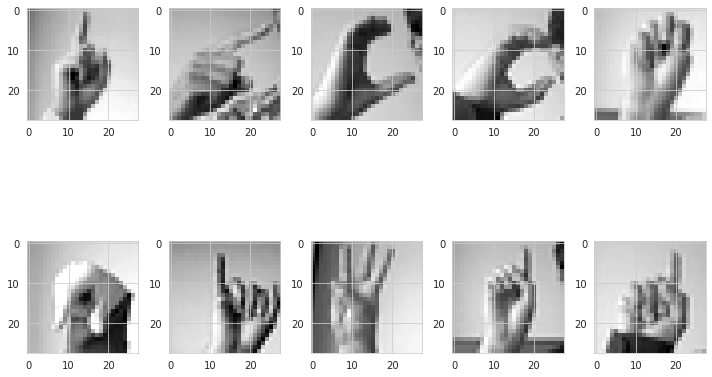

In [ ]:
# Preview of first 10 images
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()    

In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
optimizers = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']

In [ ]:
model_history_128 = list()
model_history_64 = list()
model_history_32 = list()

In [ ]:
# print("\nSGD")

# batch_size = 1

# checkpoint_filepath = f"/content/drive/My Drive/checkpoints/{batch_size}/SGD"

# model = Sequential()
# model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Flatten())
# model.add(Dense(units = 512 , activation = 'relu'))
# model.add(Dropout(0.3))
# model.add(Dense(units = 24 , activation = 'softmax'))
# model.compile(optimizer = "SGD" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
# model.summary()

# plot_model(model, to_file=f"/content/drive/My Drive/checkpoints/{batch_size}/SGD/model.png", show_shapes=True)

# # learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
# model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# model_history_128.append(model.fit(datagen.flow(x_train,y_train, batch_size=batch_size) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [model_checkpoint]))

# print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")


SGD
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 50)    

KeyboardInterrupt: ignored

In [ ]:
for opt in optimizers:
  
  print("\n", opt)

  batch_size = 128

  checkpoint_filepath = f"/content/drive/My Drive/checkpoints/{batch_size}/{opt}"

  model = Sequential()
  model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
  model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
  model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
  model.add(Flatten())
  model.add(Dense(units = 512 , activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(units = 24 , activation = 'softmax'))
  model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
  model.summary()

  plot_model(model, to_file=f"/content/drive/My Drive/checkpoints/{batch_size}/{opt}/model.png", show_shapes=True)

  learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
  model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

  model_history_128.append(model.fit(datagen.flow(x_train,y_train, batch_size=batch_size) ,epochs = 25 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction, model_checkpoint]))

  print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")


 SGD
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 50)   

In [ ]:
history_table = pd.DataFrame(columns=['Optimizer', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss'])
count = 0
for history, opt in zip(model_history_128, optimizers):
  history_table.loc[count] = [opt] + [history.history['accuracy'], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1]]
  count += 1
history_table.sort_values(by=['Validation Accuracy', 'Training Accuracy', 'Validation Loss', 'Training Loss'], inplace=True, ascending=False)
history_table

,Optimizer,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
1,RMSprop,0.999454,1.000000,0.001498,0.000016
5,Adamax,0.995993,1.000000,0.015545,0.004460
6,Nadam,0.999089,0.998745,0.003150,0.004745
0,SGD,0.969040,0.998606,0.103866,0.029535
2,Adam,0.999199,0.997630,0.003210,0.006956
4,Adagrad,0.841158,0.924568,0.488724,0.298580
3,Adadelta,0.199454,0.314138,2.706644,2.460625
7,Ftrl,0.047132,0.020078,3.178041,3.178106


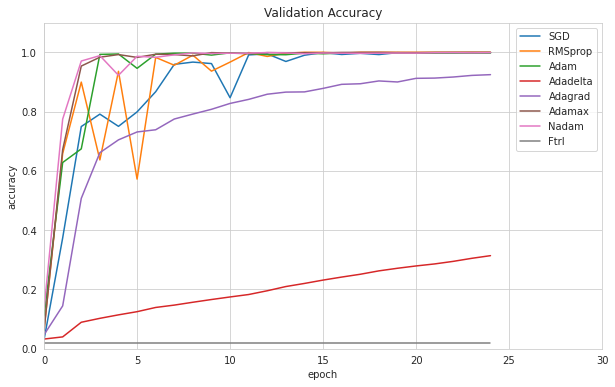

In [ ]:
plt.figure(figsize=(10, 6))
plt.axis((0, 30, 0, 1.1))  
plt.title('Validation Accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
for history, opt in zip (model_history_128, optimizers):
  plt.plot(history.history['val_accuracy'])
plt.legend(optimizers)
plt.savefig('/content/drive/My Drive/checkpoints/128/val_acc.png', dpi=96)
plt.show()

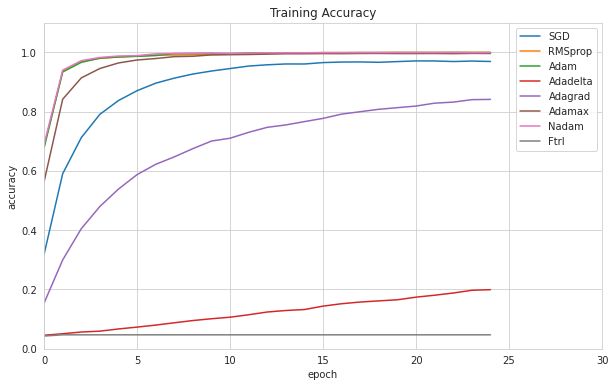

In [ ]:
plt.figure(figsize=(10, 6))
plt.axis((0, 30, 0, 1.1))  
plt.title('Training Accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
for history, opt in zip (model_history_128, optimizers):
  plt.plot(history.history['accuracy'])
plt.legend(optimizers)
plt.savefig('/content/drive/My Drive/checkpoints/128/acc.png', dpi=96)
plt.show()

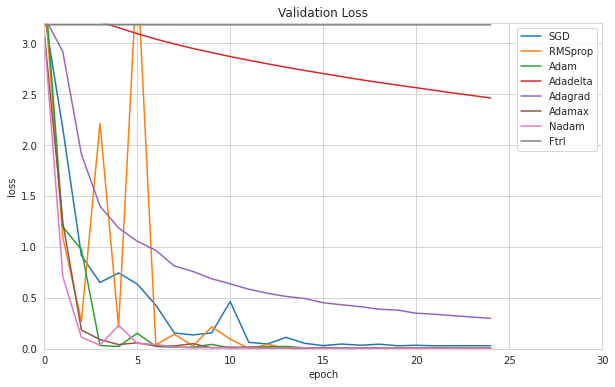

In [ ]:
plt.figure(figsize=(10, 6))
plt.axis((0, 30, 0, 3.2))  
plt.title('Validation Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
for history, opt in zip (model_history_128, optimizers):
  plt.plot(history.history['val_loss'])
plt.legend(optimizers)
plt.savefig('/content/drive/My Drive/checkpoints/128/val_loss.png', dpi=96)
plt.show()

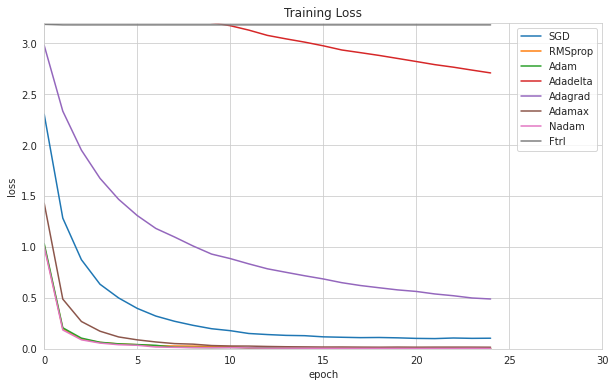

In [ ]:
plt.figure(figsize=(10, 6))
plt.axis((0, 30, 0, 3.2))  
plt.title('Training Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
for history, opt in zip (model_history_128, optimizers):
  plt.plot(history.history['loss'])
plt.legend(optimizers)
plt.savefig('/content/drive/My Drive/checkpoints/128/loss.png', dpi=96)
plt.show()

In [ ]:
for opt in optimizers:
  
  print("\n", opt)

  batch_size = 64

  checkpoint_filepath = f"/content/drive/My Drive/checkpoints/{batch_size}/{opt}"

  model = Sequential()
  model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
  model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
  model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
  model.add(Flatten())
  model.add(Dense(units = 512 , activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(units = 24 , activation = 'softmax'))
  model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
  model.summary()

  plot_model(model, to_file=f"/content/drive/My Drive/checkpoints/{batch_size}/{opt}/model.png", show_shapes=True)

  learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
  model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

  model_history_64.append(model.fit(datagen.flow(x_train,y_train, batch_size=batch_size) ,epochs = 25 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction, model_checkpoint]))

  print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")


 SGD
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization_30 (Batc (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout_20 (Dropout)         (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 7, 7, 50)  

In [ ]:
history_table = pd.DataFrame(columns=['Optimizer', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss'])
count = 0
for history, opt in zip(model_history_64, optimizers):
  history_table.loc[count] = [opt] + [history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1]]
  count += 1
history_table.sort_values(by=['Validation Accuracy', 'Training Accuracy', 'Validation Loss', 'Training Loss'], inplace=True, ascending=False)
history_table

,Optimizer,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
6,Nadam,0.999344,1.000000,0.002717,0.000143
1,RMSprop,0.999308,1.000000,0.002412,0.000015
2,Adam,0.999381,0.999861,0.002081,0.001092
5,Adamax,0.995593,0.998048,0.019745,0.006997
0,SGD,0.974394,0.994702,0.087776,0.026453
4,Adagrad,0.887088,0.968349,0.359398,0.175644
3,Adadelta,0.274231,0.406999,2.433563,2.183427
7,Ftrl,0.047132,0.020078,3.178039,3.178113


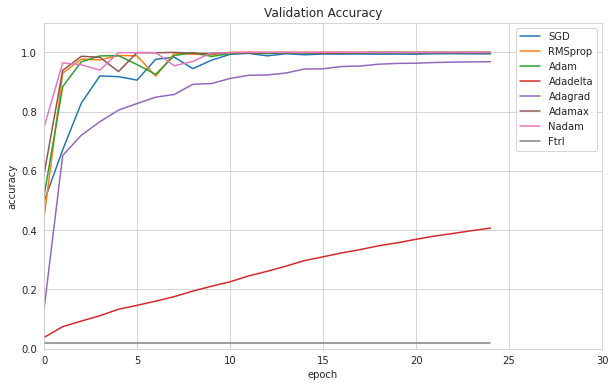

In [ ]:
plt.figure(figsize=(10, 6))
plt.axis((0, 30, 0, 1.1))  
plt.title('Validation Accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
for history, opt in zip (model_history_64, optimizers):
  plt.plot(history.history['val_accuracy'])
plt.legend(optimizers)
plt.savefig('/content/drive/My Drive/checkpoints/64/val_acc.png', dpi=96)
plt.show()

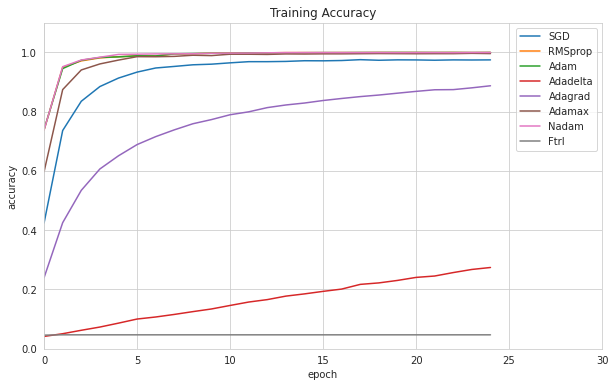

In [ ]:
plt.figure(figsize=(10, 6))
plt.axis((0, 30, 0, 1.1))  
plt.title('Training Accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
for history, opt in zip (model_history_64, optimizers):
  plt.plot(history.history['accuracy'])
plt.legend(optimizers)
plt.savefig('/content/drive/My Drive/checkpoints/64/acc.png', dpi=96)
plt.show()

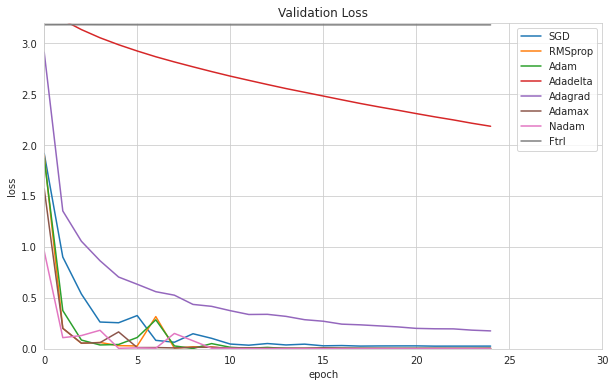

In [ ]:
plt.figure(figsize=(10, 6))
plt.axis((0, 30, 0, 3.2))  
plt.title('Validation Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
for history, opt in zip (model_history_64, optimizers):
  plt.plot(history.history['val_loss'])
plt.legend(optimizers)
plt.savefig('/content/drive/My Drive/checkpoints/64/val_loss.png', dpi=96)
plt.show()

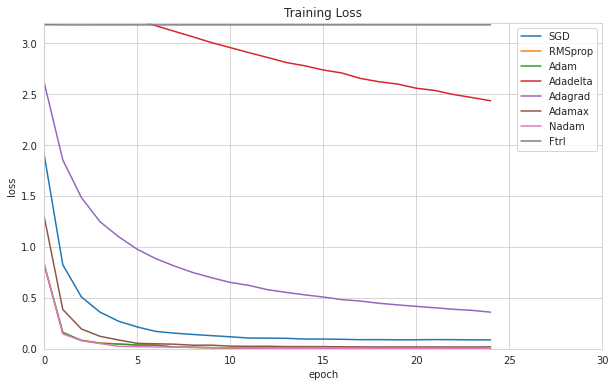

In [ ]:
plt.figure(figsize=(10, 6))
plt.axis((0, 30, 0, 3.2))  
plt.title('Training Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
for history, opt in zip (model_history_64, optimizers):
  plt.plot(history.history['loss'])
plt.legend(optimizers)
plt.savefig('/content/drive/My Drive/checkpoints/64/loss.png', dpi=96)
plt.show()

In [ ]:
for opt in optimizers:
  
  print("\n", opt)

  batch_size = 32

  checkpoint_filepath = f"/content/drive/My Drive/checkpoints/{batch_size}/{opt}"

  model = Sequential()
  model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
  model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
  model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
  model.add(Flatten())
  model.add(Dense(units = 512 , activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(units = 24 , activation = 'softmax'))
  model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
  model.summary()

  plot_model(model, to_file=f"/content/drive/My Drive/checkpoints/{batch_size}/{opt}/model.png", show_shapes=True)

  learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
  model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

  model_history_32.append(model.fit(datagen.flow(x_train,y_train, batch_size=batch_size) ,epochs = 25 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction, model_checkpoint]))

  print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")


 SGD
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization_63 (Batc (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout_42 (Dropout)         (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 7, 7, 50)  

In [ ]:
history_table = pd.DataFrame(columns=['Optimizer', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss'])
count = 0
for history, opt in zip(model_history_32, optimizers):
  history_table.loc[count] = [opt] + [history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1]]
  count += 1
history_table.sort_values(by=['Validation Accuracy', 'Training Accuracy', 'Validation Loss', 'Training Loss'], inplace=True, ascending=False)
history_table

,Optimizer,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
5,Adamax,0.997232,1.000000,0.011181,0.001865
0,SGD,0.991076,1.000000,0.030421,0.004201
6,Nadam,0.999381,0.999582,0.002099,0.001637
1,RMSprop,0.999162,0.999303,0.002935,0.001858
2,Adam,0.999235,0.997072,0.002178,0.019150
4,Adagrad,0.900637,0.975878,0.316160,0.143341
3,Adadelta,0.322856,0.477273,2.222674,1.944006
7,Ftrl,0.047132,0.020078,3.178025,3.178116


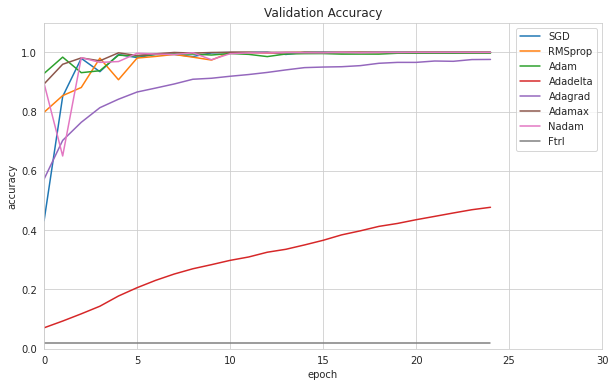

In [ ]:
plt.figure(figsize=(10, 6))
plt.axis((0, 30, 0, 1.1))  
plt.title('Validation Accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
for history, opt in zip (model_history_32, optimizers):
  plt.plot(history.history['val_accuracy'])
plt.legend(optimizers)
plt.savefig('/content/drive/My Drive/checkpoints/32/val_acc.png', dpi=96)
plt.show()

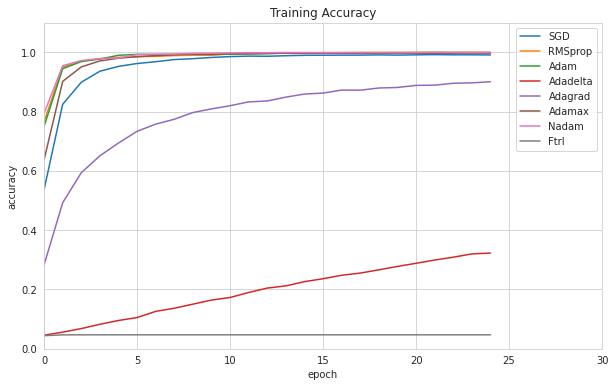

In [ ]:
plt.figure(figsize=(10, 6))
plt.axis((0, 30, 0, 1.1))  
plt.title('Training Accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
for history, opt in zip (model_history_32, optimizers):
  plt.plot(history.history['accuracy'])
plt.legend(optimizers)
plt.savefig('/content/drive/My Drive/checkpoints/32/acc.png', dpi=96)
plt.show()

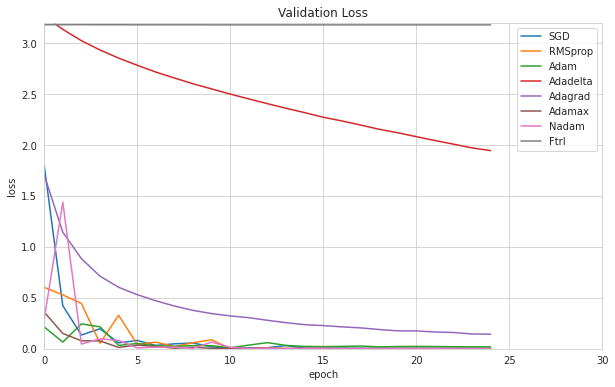

In [ ]:
plt.figure(figsize=(10, 6))
plt.axis((0, 30, 0, 3.2))  
plt.title('Validation Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
for history, opt in zip (model_history_32, optimizers):
  plt.plot(history.history['val_loss'])
plt.legend(optimizers)
plt.savefig('/content/drive/My Drive/checkpoints/32/val_loss.png', dpi=96)
plt.show()

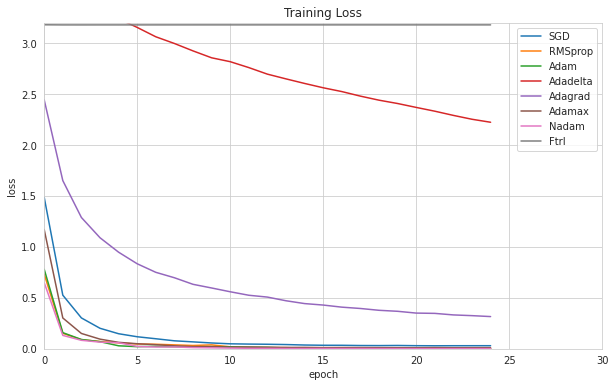

In [ ]:
plt.figure(figsize=(10, 6))
plt.axis((0, 30, 0, 3.2))  
plt.title('Training Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
for history, opt in zip (model_history_32, optimizers):
  plt.plot(history.history['loss'])
plt.legend(optimizers)
plt.savefig('/content/drive/My Drive/checkpoints/32/loss.png', dpi=96)
plt.show()